In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMAGE_SIZE = (48,48)
BATCH_SIZE = 64
SAMPLES_PER_CLASS_TRAIN = 3000
SAMPLES_PER_CLASS_TEST = 571

In [5]:
data_train = r"C:\KULIAH SEMESTER 3\Kecerdasan Artifisial\FER 2013\train"
data_test = r"C:\KULIAH SEMESTER 3\Kecerdasan Artifisial\FER 2013\test"

In [6]:
def load_dataset_with_undersampling_and_hog(directory, samples_per_class):
    images_hog = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            # List semua file dalam direktori kelas ini
            image_files = os.listdir(label_path)
            # Lakukan undersampling
            sampled_files = random.sample(image_files, min(samples_per_class, len(image_files)))
            for image_file in sampled_files:
                image_path = os.path.join(label_path, image_file)
                # Baca gambar dalam grayscale dan resize
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, IMAGE_SIZE)

                # Ekstraksi fitur HOG
                hog_features = hog(
                    image,
                    orientations=9,  # Jumlah orientasi (bin)
                    pixels_per_cell=(8, 8),  # Ukuran sel
                    cells_per_block=(2, 2),  # Ukuran blok
                    block_norm='L2-Hys',  # Normalisasi blok
                    visualize=False  # Tidak menghasilkan gambar visualisasi
                )
                images_hog.append(hog_features)
                labels.append(label)
    return np.array(images_hog), np.array(labels)

In [8]:
x_train, y_train = load_dataset_with_undersampling_and_hog(data_train, SAMPLES_PER_CLASS_TRAIN)
x_test, y_test = load_dataset_with_undersampling_and_hog(data_test, SAMPLES_PER_CLASS_TEST)

In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(18436, 900)
(18436,)
(3537, 900)
(3537,)


In [10]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

In [ ]:
print(x_train.shape[0], y_train_encoded.shape[0])

In [11]:
x_train.shape

(18436, 900)

In [12]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [14]:
y_train_encoded

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

In [15]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(x_train.shape)
print(x_test.shape)

(18436, 900, 1)
(3537, 900, 1)


In [16]:
x_train[0].shape

(900, 1)

In [17]:
x_train_flatten = x_train.reshape(len(x_train), -1)
x_test_flatten = x_test.reshape(len(x_test), -1)

x_train_flatten.shape

(18436, 900)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
x_train_pca = pca.fit_transform(x_train_flatten)
x_test_pca = pca.transform(x_test_flatten)

x_train_pca.shape


(9004, 100)

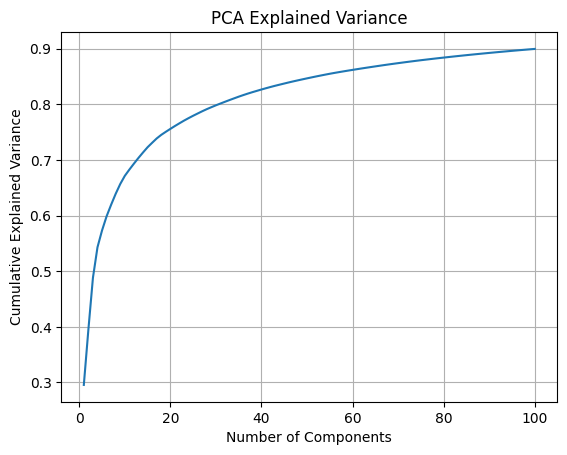

In [ ]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.show()

NameError: name 'pca' is not defined

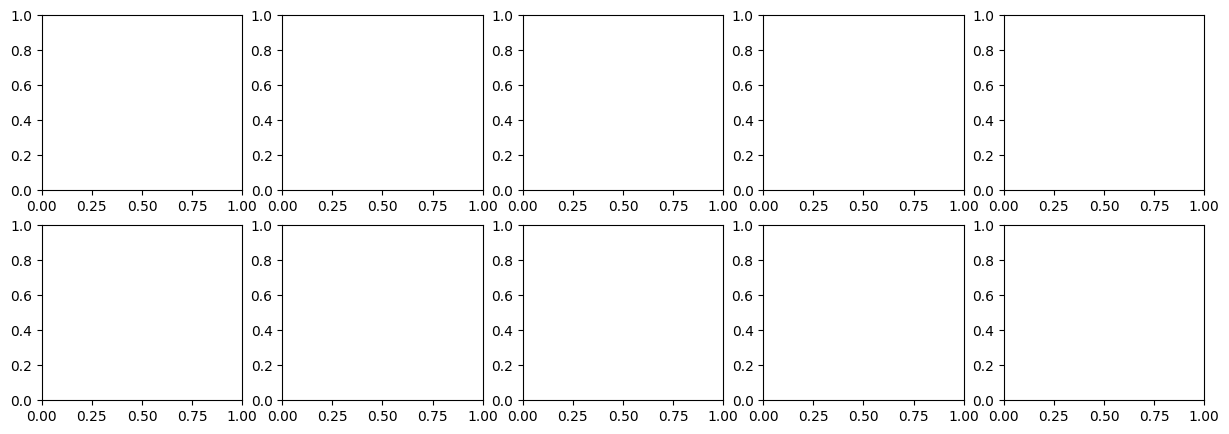

In [13]:
n_samples = 5
fig, axes = plt.subplots(2, n_samples, figsize=(15, 5))
for i in range(n_samples):
    original = x_train[i]
    reconstructed = pca.inverse_transform(x_train_pca[i].reshape(1, -1)).reshape(48, 48)
    axes[0, i].imshow(original, cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")
    axes[1, i].imshow(reconstructed, cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")
plt.tight_layout()
plt.show()

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
# Inisialisasi model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Melatih model menggunakan data hasil PCA
rf_model.fit(x_train, y_train_encoded)

# Prediksi pada data uji
y_pred = rf_model.predict(x_test)


In [9]:
# Evaluasi performa model
print("Akurasi:", accuracy_score(y_test_encoded, y_pred))
print("\nLaporan Klasifikasi:\n", classification_report(y_test_encoded, y_pred))


Akurasi: 0.4280463669776647

Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.36      0.37      0.36       571
           1       1.00      0.28      0.44       111
           2       0.33      0.29      0.31       571
           3       0.49      0.64      0.56       571
           4       0.38      0.37      0.37       571
           5       0.30      0.27      0.29       571
           6       0.62      0.65      0.63       571

    accuracy                           0.43      3537
   macro avg       0.50      0.41      0.42      3537
weighted avg       0.43      0.43      0.42      3537



In [ ]:
# Uji jumlah komponen yang berbeda
for n_components in [100, 200, 300, 500]:
    pca = PCA(n_components=n_components)
    x_train_pca = pca.fit_transform(x_train_flatten)
    x_test_pca = pca.transform(x_test_flatten)

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(x_train_pca, y_train_encoded)
    y_pred = rf_model.predict(x_test_pca)

    acc = accuracy_score(y_test_encoded, y_pred)
    print(f"n_components={n_components}, Akurasi: {acc}")


n_components=100, Akurasi: 0.36188860616341534
n_components=200, Akurasi: 0.336160588068985
n_components=300, Akurasi: 0.31439072660446704
n_components=500, Akurasi: 0.28527000282725473


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(x_train, y_train_encoded)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 300}
Best Accuracy: 0.40759561010938467


In [22]:
import numpy as np
from collections import Counter
from joblib import Parallel, delayed


class Node:
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    @staticmethod
    def _entropy(s):
        counts = np.bincount(np.array(s, dtype=int))
        percentages = counts / len(s)
        entropy = -np.sum(p * np.log2(p) for p in percentages if p > 0)
        return entropy

    def _information_gain(self, parent, left_child, right_child):
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))

    def _best_split(self, X, y):
        best_split = {}
        best_info_gain = -1
        n_rows, n_cols = X.shape

        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            unique_vals = np.unique(X_curr)
            thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2  # Midpoints as thresholds

            for threshold in thresholds:
                mask = X_curr <= threshold
                y_left, y_right = y[mask], y[~mask]

                if len(y_left) > 0 and len(y_right) > 0:
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'mask_left': mask,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split

    def _build(self, X, y, depth=0):
        if len(y) >= self.min_samples_split and depth <= self.max_depth:
            best = self._best_split(X, y)
            if best.get('gain', 0) > 0:
                left = self._build(X[best['mask_left']], y[best['mask_left']], depth + 1)
                right = self._build(X[~best['mask_left']], y[~best['mask_left']], depth + 1)
                return Node(feature=best['feature_index'], threshold=best['threshold'],
                            data_left=left, data_right=right, gain=best['gain'])
        return Node(value=Counter(y).most_common(1)[0][0])

    def fit(self, X, y):
        self.root = self._build(X, y)

    def _predict(self, x, tree):
        if tree.value is not None:
            return tree.value
        if x[tree.feature] <= tree.threshold:
            return self._predict(x, tree.data_left)
        return self._predict(x, tree.data_right)

    def predict(self, X):
        return [self._predict(x, self.root) for x in X]


class RandomForest_manual:
    def __init__(self, num_trees=25, min_samples_split=2, max_depth=5):
        self.num_trees = num_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.decision_trees = []

    @staticmethod
    def _sample(X, y):
        np.random.seed(42)
        n_rows = X.shape[0]
        indices = np.random.choice(n_rows, size=n_rows, replace=True)
        X_sample, y_sample = X[indices], y[indices]
        
        # Menghapus dimensi channel tambahan (C=1)
        X_sample = np.squeeze(X_sample)  # Menghapus dimensi 1
        print(f"Sampled X shape after squeeze: {X_sample.shape}")  # Debugging
        print(f"Sampled y shape: {y_sample.shape}")  # Debugging
        return X_sample, y_sample




    def fit_tree(self, X, y):
        print(f"Fitting tree with X shape: {X.shape}, y shape: {y.shape}")  # Debugging
        tree = DecisionTree(min_samples_split=self.min_samples_split, max_depth=self.max_depth)
        tree.fit(X, y)
        return tree


    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        # Menghapus dimensi ekstra jika ada
        X = np.squeeze(X)  # Pastikan bentuknya adalah (n_samples, n_features)
        
        print(f"Shape of X before training: {X.shape}")  # Debugging
        print(f"Shape of y: {y.shape}")  # Debugging
        
        self.decision_trees = Parallel(n_jobs=-1)(
            delayed(self.fit_tree)(*self._sample(X, y)) for _ in range(self.num_trees)
        )


    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.decision_trees])
        predictions = [Counter(tree_predictions[:, i]).most_common(1)[0][0] for i in range(X.shape[0])]
        return predictions


In [20]:
import numpy as np
from collections import Counter


class Node:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    @staticmethod
    def _entropy(s):
        '''
        Helper function, calculates entropy from an array of integer values.

        :param s: list
        :return: float, entropy value
        '''
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabilities of each class label
        percentages = counts / len(s)

        # Caclulate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy

    def _information_gain(self, parent, left_child, right_child):
        '''
        Helper function, calculates information gain from a parent and two child nodes.

        :param parent: list, the parent node
        :param left_child: list, left child of a parent
        :param right_child: list, right child of a parent
        :return: float, information gain
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)

        # One-liner which implements the previously discussed formula
        return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))

    def _best_split(self, X, y):
        '''
        Helper function, calculates the best split for given features and target

        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''
        best_split = {}
        best_info_gain = -1
        n_rows, n_cols = X.shape

        # For every dataset feature
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                # Construct a dataset and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    # Obtain the value of the target variable for subsets
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Caclulate the information gain and save the split parameters
                    # if the current split if better then the previous best
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split

    def _build(self, X, y, depth=0):
        '''
        Helper recursive function, used to build a decision tree from the input data.

        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape

        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(X, y)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    X=best['df_left'][:, :-1],
                    y=best['df_left'][:, -1],
                    depth=depth + 1
                )
                right = self._build(
                    X=best['df_right'][:, :-1],
                    y=best['df_right'][:, -1],
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'],
                    threshold=best['threshold'],
                    data_left=left,
                    data_right=right,
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )

    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.

        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self._build(X, y)

    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).

        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]

        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)

        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)

    def predict(self, X):
        '''
        Function used to classify new instances.

        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

class RandomForest:
    '''
    A class that implements Random Forest algorithm from scratch.
    '''
    def __init__(self, num_trees=25, min_samples_split=2, max_depth=5):
        self.num_trees = num_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        # Will store individually trained decision trees
        self.decision_trees = []

    @staticmethod
    def _sample(X, y):
        '''
        Helper function used for boostrap sampling.

        :param X: np.array, features
        :param y: np.array, target
        :return: tuple (sample of features, sample of target)
        '''
        n_rows, n_cols = X.shape
        # Sample with replacement
        samples = np.random.choice(a=n_rows, size=n_rows, replace=True)
        return X[samples], y[samples]

    def fit(self, X, y):
        '''
        Trains a Random Forest classifier.

        :param X: np.array, features
        :param y: np.array, target
        :return: None
        '''
        # Reset
        if len(self.decision_trees) > 0:
            self.decision_trees = []

        # Build each tree of the forest
        num_built = 0
        while num_built < self.num_trees:
            try:
                clf = DecisionTree(
                    min_samples_split=self.min_samples_split,
                    max_depth=self.max_depth
                )
                # Obtain data sample
                _X, _y = self._sample(X, y)
                # Train
                clf.fit(_X, _y)
                # Save the classifier
                self.decision_trees.append(clf)
                num_built += 1
            except Exception as e:
                continue

    def predict(self, X):
        '''
        Predicts class labels for new data instances.

        :param X: np.array, new instances to predict
        :return:
        '''
        # Make predictions with every tree in the forest
        y = []
        for tree in self.decision_trees:
            y.append(tree.predict(X))

        # Reshape so we can find the most common value
        y = np.swapaxes(a=y, axis1=0, axis2=1)

        # Use majority voting for the final prediction
        predictions = []
        for preds in y:
            counter = Counter(x)
            predictions.append(counter.most_common(1)[0][0])
        return predictions

In [18]:
class RandomForest:
    def __init__(self, num_trees=25, min_samples_split=2, max_depth=5, n_jobs=-1):
        self.num_trees = num_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_jobs = n_jobs
        self.decision_trees = []

    @staticmethod
    def _sample(X, y):
        '''
        Helper function used for bootstrap sampling.

        :param X: np.array, features
        :param y: np.array, target
        :return: tuple (sample of features, sample of target)
        '''
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def _train_tree(self, X, y):
        '''
        Train a single DecisionTree using sampled data.

        :param X: np.array, features
        :param y: np.array, target
        :return: trained DecisionTree
        '''
        tree = DecisionTree(
            min_samples_split=self.min_samples_split,
            max_depth=self.max_depth
        )
        X_sample, y_sample = self._sample(X, y)
        tree.fit(X_sample, y_sample)
        return tree

    def fit(self, X, y):
        '''
        Train the RandomForest model using multiple DecisionTrees.

        :param X: np.array, features
        :param y: np.array, target
        '''
        self.decision_trees = Parallel(n_jobs=self.n_jobs)(
            delayed(self._train_tree)(X, y) for _ in range(self.num_trees)
        )

    def predict(self, X):
        '''
        Predict the class labels for the input data.

        :param X: np.array, features
        :return: np.array, predicted labels
        '''
        predictions = np.array([tree.predict(X) for tree in self.decision_trees])
        final_predictions = np.apply_along_axis(
            lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions
        )
        return final_predictions


In [23]:
rf = RandomForest_manual(num_trees= 25)
# rf = RandomForest_manual(num_trees= 25, min_sample_split = 2, max_depth = 5)
rf.fit(x_train, y_train_encoded)
y_pred2 = rf.predict(x_test)

Shape of X before training: (18436, 900)
Shape of y: (18436,)
Sampled X shape after squeeze: (18436, 900)
Sampled y shape: (18436,)
Sampled X shape after squeeze: (18436, 900)
Sampled y shape: (18436,)
Sampled X shape after squeeze: (18436, 900)
Sampled y shape: (18436,)
Sampled X shape after squeeze: (18436, 900)
Sampled y shape: (18436,)
Sampled X shape after squeeze: (18436, 900)
Sampled y shape: (18436,)
Sampled X shape after squeeze: (18436, 900)
Sampled y shape: (18436,)
Sampled X shape after squeeze: (18436, 900)
Sampled y shape: (18436,)
Sampled X shape after squeeze: (18436, 900)
Sampled y shape: (18436,)
Sampled X shape after squeeze: (18436, 900)
Sampled y shape: (18436,)
Sampled X shape after squeeze: (18436, 900)
Sampled y shape: (18436,)
Sampled X shape after squeeze: (18436, 900)
Sampled y shape: (18436,)
Sampled X shape after squeeze: (18436, 900)
Sampled y shape: (18436,)
Sampled X shape after squeeze: (18436, 900)
Sampled y shape: (18436,)
Sampled X shape after squeez

In [26]:
from sklearn.metrics import classification_report

# Menghitung classification report
report = classification_report(y_test_encoded, y_pred2)

# Menampilkan classification report
print("Classification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

           0       0.18      0.17      0.17       571
           1       0.50      0.02      0.03       111
           2       0.18      0.11      0.13       571
           3       0.30      0.45      0.36       571
           4       0.24      0.26      0.25       571
           5       0.20      0.15      0.17       571
           6       0.32      0.44      0.37       571

    accuracy                           0.25      3537
   macro avg       0.27      0.23      0.21      3537
weighted avg       0.25      0.25      0.24      3537



In [24]:
from joblib import dump, load

# Menyimpan model ke file .joblib
dump(rf, 'random_forest_model.joblib')
print("Model berhasil disimpan ke random_forest_model.joblib")


Model berhasil disimpan ke random_forest_model.joblib


In [25]:
import pickle

# Menyimpan model ke file .pkl
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf, file)
print("Model berhasil disimpan ke random_forest_model.pkl")


Model berhasil disimpan ke random_forest_model.pkl
